In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Circle
from matplotlib.patches import Wedge
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt
from bfields import *
from efields import *
from plottools import *
from boris import *

import pymms.data
from pymms.data import util, edi, fpi, anc


# Use %matplotlib notebook to change to a zoom-able display.
%matplotlib inline

# Distribution Plots based on Menz et al. 2019, Fig. 4

**Step 0.1 Constants**

In [2]:
RE = 6371000    # radius of earth [m] 
mp = 1.6e-27    # proton mass [kg]
me = 9.1e-31    # electron mass [kg]
qe = 1.603E-19  # proton charge [C]

# creating charged particle / particle packet
m = mp*4
q = qe*2


**Step 0.2 Select time of MMS orbit, load data**

In [3]:
t0 = dt.datetime(2020, 6, 29, 0)
t1 = dt.datetime(2020, 6, 29, 12)

r_vname = '_'.join(('mms1', 'mec', 'r', 'gse'))

mec_data = util.load_data(sc='mms1', 
                        instr='mec', mode='srvy', 
                        level='l2', optdesc='epht89d', 
                        start_date=t0, 
                        end_date=t1, 
                        variables=r_vname)

**Step 1. Find the position of MMS on inbound leg of orbit from L=10 to L=3**

Note: Currently not accounting for distance contraint L[3:10], so mms may be out of this range.

In [4]:

# get mms position values in [km] and convert to array in units [m]
pos = mec_data['mms1_mec_r_gse'].to_numpy()*1.e3

# check
print(pos/RE)

[[-20.80122566 -19.00797759   1.88326902]
 [-20.79962362 -19.00880821   1.88139501]
 [-20.79802031 -19.00963768   1.87952088]
 ...
 [-17.15341045 -18.92140093  -0.87526498]
 [-17.14989845 -18.92035949  -0.87718331]
 [-17.14638499 -18.91931651  -0.87910155]]


**Step 2. Find energy bins**

In [5]:
def get_vcomponents(energy, mass, theta, phi):
    
    # velcoity magnitude 
    vmag = np.sqrt(2*energy*(1/mass))
    
    # velocity components [UNITS]
    vx = vmag*np.sin(theta)*np.cos(phi)
    vy = vmag*np.sin(theta)*np.sin(phi)
    vz = vmag*np.cos(theta)
    
    return np.array([vx,vy,vz])



# pull dataset
dis_data = fpi.load_dist(sc='mms1', mode='srvy', optdesc='dis-dist', start_date=t0, end_date=t1)



In [10]:
# get energy bins at initial time in units [eV]
ebins = dis_data['energy'][0].to_numpy()

# convert to [J]
ebins = ebins*1.602176e-19

# get angle data
phidat = dis_data['phi'].to_numpy()
thetadat = dis_data['theta'].to_numpy()

# find velocity magnetiude [m/s]
#vmag_mms = [np.sqrt(2*i/mp) for i in ebin0]
#vbins = [get_vcomponents(e0, m, )]

vdat = np.zeros((32,3))

for i in range(0,32):
    vdat[i] = get_vcomponents(ebins[i], m, thetadat[3], phidat[3])
    
# note: There are 32 energy bins, but 16 angle (theta, phi) values, not sure how to go about this
#       so currently all inital angles are the same.

# check
print(vdat)

[[ 3.75606169e+03 -9.63581119e+03 -1.09087819e+03]
 [ 5.05352272e+03 -1.29643214e+04 -1.46770160e+03]
 [ 6.79540827e+03 -1.74329594e+04 -1.97359983e+03]
 [ 8.44920655e+03 -2.16756182e+04 -2.45391475e+03]
 [ 9.72165277e+03 -2.49399553e+04 -2.82347307e+03]
 [ 1.11867410e+04 -2.86984967e+04 -3.24898066e+03]
 [ 1.28725941e+04 -3.30233891e+04 -3.73860532e+03]
 [ 1.48119024e+04 -3.79984959e+04 -4.30184130e+03]
 [ 1.70446555e+04 -4.37264070e+04 -4.95030288e+03]
 [ 1.96122136e+04 -5.03132279e+04 -5.69600234e+03]
 [ 2.25682278e+04 -5.78965949e+04 -6.55452163e+03]
 [ 2.59674817e+04 -6.66170505e+04 -7.54177165e+03]
 [ 2.98806531e+04 -7.66559112e+04 -8.67827942e+03]
 [ 3.43821577e+04 -8.82040840e+04 -9.98565765e+03]
 [ 3.95618358e+04 -1.01492045e+05 -1.14899987e+04]
 [ 4.55226135e+04 -1.16783840e+05 -1.32211956e+04]
 [ 5.23813880e+04 -1.34379360e+05 -1.52131990e+04]
 [ 6.02738763e+04 -1.54626771e+05 -1.75054253e+04]
 [ 6.93549507e+04 -1.77923385e+05 -2.01428543e+04]
 [ 7.98042388e+04 -2.04730018e+

**Step 3. For each position, launch 32 particles, one for each energy, and trace backwards for ~11 hours (40000s).**

According to Menz (2019) Fig. 4, the drift time should range from 1 hr (3600s) to 10 hrs (36000s)

In [7]:
# constants and constraints
kp = 8.5        # kp index
gs = 2.0        # shielding constant

tf = 40000      # duration time (code will run for this exact time, regardless if L=10 crossed or not)
dt = 0.01       # tiemstep

# inital parameters
rdat_mms = pos  # intial position (see Step 1.)
vdat_mms = vdat # intial velocity (see Step 2.)

# fake data (ignore)
# rdat_mms = np.random.uniform(low=1, high=8., size=(7,3))*RE
# vdat_mms = np.random.uniform(low=-4., high=4., size=(10,3))

nstep = len(rdat_mms)*len(vdat_mms)

lshell_dat = np.zeros(nstep)
tdrift_dat = np.zeros(nstep)
energy_dat = np.zeros(nstep)

count = 0

for r0 in rdat_mms:
    for v0 in vdat_mms:
        
        tdat, tdrift, vdat, rdat, emag = boris(tf, r0, 0., m, q, gs, kp, tdir='bw')
        """
        boris.py output key:
        
        tdat (ndarray): time data in units [s]
        tdrift (ndarray): drift time in units [s]
        vdat (ndarray): velocity data in units [m/s]
        rdat (ndarray): position data in units [m]
        emag (ndarray): magnitude of total E-field in units [mV/m]
        """
        
        # find initial L-shell [RE]
        lshell = mag(r0)/RE
        
        #print('lshell = ', lshell)
        
        # find inital energy [J]
        enval = 0.5*m*mag(v0)**2
        
        # convert energy to keV
        enval = enval*6.242e+15
        
        # append data to arrays
        lshell_dat[count] = lshell
        energy_dat[count] = enval
        
        # print dirft time in units [hr]
        print('tdrift [hr] = ',tdrift/3600)
            
        # count incrmenet
        count += 1

        

tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] =  0.0
tdrift [hr] 

KeyboardInterrupt: 

IGNORE EVERYHTHING BELOW

In [ ]:
for r0 in rdat_mms:
    print(mag(r0)/RE)

4.839483136617283
9.144946152242627
5.724976155466459
10.603207034997151
8.358398192319207
8.573795289196676
9.228019946080648


In [ ]:
#print(lshell_dat)
print(tdrift_dat)
#print(energy_dat)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


## Plot

ValueError: not enough values to unpack (expected 2, got 1)

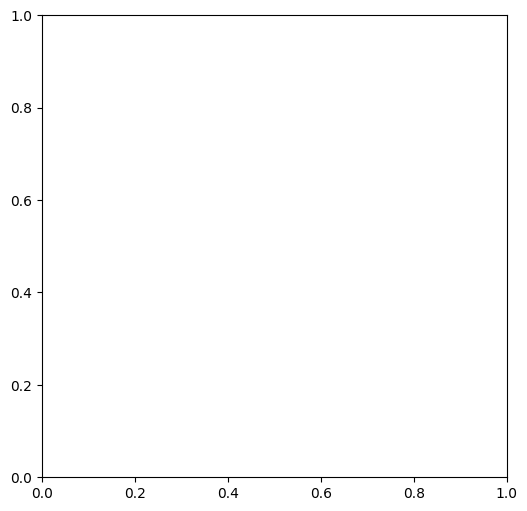

In [ ]:
# scale coordinates in units [RE] 
# rscale = lshell_dat/RE

# scale drift time in units [hr]
tscale = [val/3600 for val in tdrift_dat]

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(6,6))
ax1 = axes[0, 0]

# plot convection potential
#plot1 = ax1.pcolormesh(lshell_dat, energy_dat, tscale, cmap ='Greens', shading='nearest')
plot1 = ax1.pcolormesh(lshell_dat, energy_dat, tscale, cmap ='Greens', shading='nearest')
fig.colorbar(plot1, ax=ax1, pad=0.13, fraction=0.04, label="Drift Time [hr]")


ValueError: not enough values to unpack (expected 2, got 1)

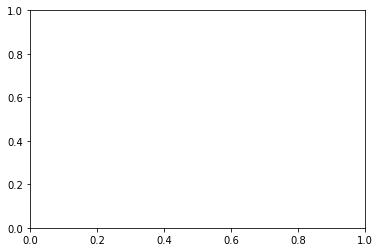

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.pcolorfast(lshell_dat, energy_dat, tscale)
ax.images.append(im)
ax.set_title(title)
ax.set_ylabel('f (Hz)')
ax.set_ylim(f[1], f[-1])
ax.set_yscale('log')


In [ ]:
v0ff = vdat[-1]
r0ff = rdat[-1]

In [ ]:
print('fw initial velcoity [m/s]: ',v0f0)
print('fw initial position [RE]: ',r0f0/RE) 
print('fw final velcoity /bw initial [m/s]: ',v0ff) 
print('fw final position /bw initial  [RE]: ',r0ff/RE)

print('fw final velcoity [m/s]: ',vdat[-1]) 
print('fw final position [RE]: ',rdat[-1]/RE)


print('mag(v0) = ',mag(v0f0),'mag(vf) = ',mag(vdat[-1]))

print(rdat[-1]/RE)

fw initial velcoity [m/s]:  [11.48004243  2.45958841 -0.49026657]
fw initial position [RE]:  [ 1.   -3.85 -1.53]
fw final velcoity /bw initial [m/s]:  [  67993.41814924 -221671.17466222  124795.84882849]
fw final position /bw initial  [RE]:  [ 1.15545419 -4.50529965 -1.31675769]
fw final velcoity [m/s]:  [ 7.01483771 -2.71809189  0.93727042]
fw final position [RE]:  [ 1.00000083 -3.8500019  -1.52999923]
mag(v0) =  11.750800425965295 mag(vf) =  7.581190368769779
[ 1.00000083 -3.8500019  -1.52999923]


In [ ]:
# velcoity magnitude
vmag = np.sqrt(2*en*(1/mo))


# velcoity components
vx = vmag*np.sin(theta1)*np.cos(phi1)
vy = vmag*np.sin(theta1)*np.sin(phi1)
vz = vmag*np.cos(theta1)

NameError: name 'en' is not defined

In [ ]:
ne = 5e5*1e6
me = 9.109e-31
e = 1.602e-19
e0 = 8.854e-12
wpe = np.sqrt((ne*e**2)/(e0*me))
wce = (e*b)/me

b = 3e-5

In [ ]:
(4.8065e-19/1.67e-27)**(1/2)

16965.09272764181

Step 4. 